In [2]:
mne.__version__

'0.11.0'

In [3]:
%pylab inline 

import mne
from mne.datasets import spm_face
from mne.decoding import GeneralizationAcrossTime
import sys
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from scipy import stats
#Add personal functions to python path
sys.path.append('/Users/pinheirochagas/Pedro/NeuroSpin/Experiments/Calc_MEG/scripts/decoding/')
from fldtrp2mne import fldtrp2mne
from sklearn import svm
from sklearn.cross_validation import cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import StratifiedKFold

Populating the interactive namespace from numpy and matplotlib


/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'confi

In [4]:
#Directories
data_path = '/Users/pinheirochagas/Pedro/NeuroSpin/Experiments/Calc_MEG/data/mat/'
result_path = '/Users/pinheirochagas/Pedro/NeuroSpin/Experiments/Calc_MEG/data/decoding/'

#Subjects
subjects = 's01'

#General parameters
baseline = (-0.5, -0.05)
downsampling = 4

#Decoding
trainset = 'all'
testset = 'all'
decCond = ['addition', 'subtraction']

params = {'baseline': baseline, 'downsampling': downsampling, 
'Classification': decCond, 'trainset': trainset, 'testset': testset}

#Results initialization
all_scores = []
all_diagonals = []


In [5]:
fname

NameError: name 'fname' is not defined

In [6]:
#Load filtered MEG data from fieldtrip
print('Loading data for subject: ' + subjects)
    
fname = op.join(data_path, subjects + '_calc.mat') 
epoch = fldtrp2mne(fname, 'data')

matfile = sio.loadmat(fname)

trialinfo = matfile['data']['trialinfo']

operator = trialinfo[0][0][0][0][2].T
operand1 = trialinfo[0][0][0][0][1].T


Loading data for subject: s01


In [7]:
info = pd.DataFrame(data = np.concatenate((operator, operand1), axis = 1), 
                        columns = ['operation', 'operand1'])

In [8]:
addition = info['operation'] == 1
subtraction = info['operation'] == -1

add_sub = info['operation'] != 0

condA = addition
condB = subtraction

In [9]:
evoked_condA = epoch[condA].average() #seen
evoked_condB = epoch[condB].average() #unseen


/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


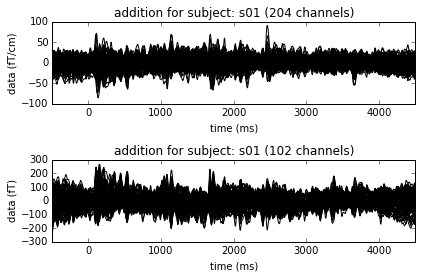

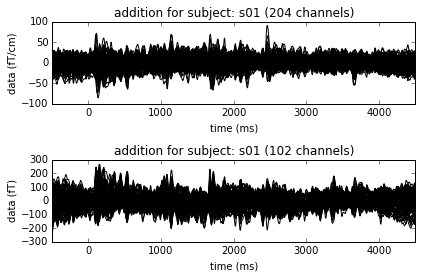

In [10]:
evoked_condB.plot(titles = decCond[0] + ' for subject: ' + subjects, show = False)

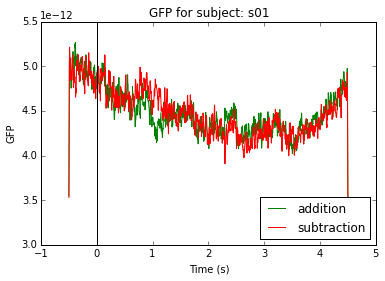

In [11]:
gfp_condA = np.median(np.std(epoch[condA]._data, axis = 1), axis = 0) #do I need to make sure that the number of trials is similar in the two conditions?
gfp_condB = np.median(np.std(epoch[condB]._data, axis = 1), axis = 0)
    
plt.plot(epoch.times, gfp_condA, color = 'g', label = decCond[0])
plt.plot(epoch.times, gfp_condB, color = 'r', label = decCond[1])
plt.axvline(0, color = 'k') #mark stimulus onset
plt.legend(loc = 'lower right')
plt.xlabel('Time (s)')
plt.ylabel('GFP')
plt.title('GFP for subject: ' + subjects)
plt.show()

In [12]:
# Decoding
epochs = epoch[add_sub] #select only target-present trials
info = info[add_sub]
y = np.array(info['operation']) #select labels for seen vs. unseen


In [13]:
epochs.decimate(4)

/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/mne/epochs.py:394: UserWarning: The measurement information indicates a low-pass frequency of 125 Hz. The decim=4 parameter will result in a sampling frequency of 62.5 Hz, which can cause aliasing artifacts.
  % (lowpass, decim, new_sfreq))  # > 50% nyquist limit


<EpochsArray  |  n_events : 286 (all good), tmin : -0.5 (s), tmax : 4.492 (s), baseline : None>

In [14]:
type(y[0])

y = y.astype(numpy.float64)

In [23]:
score = []
scaler = StandardScaler();
model = svm.SVC(C = 1, kernel = 'linear', class_weight = 'auto')
clf = make_pipeline(scaler, model)
cv = StratifiedKFold(y, 5)


In [24]:
gat = GeneralizationAcrossTime(clf=clf, cv=cv, n_jobs=-1)


In [25]:
epochs

<EpochsArray  |  n_events : 286 (all good), tmin : -0.5 (s), tmax : 4.492 (s), baseline : None>

In [26]:
gat.fit(epochs, y=y)


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.4min remaining:  4.1min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.4min remaining:   28.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:  1.4min remaining: 10.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.4min finished


<GAT | fitted, start : -0.500 (s), stop : 4.492 (s), no prediction, no score>

In [ ]:
gat.score(epochs, y=y)
gat.plot()

/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:96: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:675: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/Users/pinheirochagas/anac

'0.11.0'